In [1]:
!pip install yfinance plotly dash dash-bootstrap-components tensorflow


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.9/7.9 MB 103.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 204.0/204.0 kB 14.4 MB/s eta 0:00:00


Plot Interactive Stock Chart

In [37]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from dash import Dash, dcc, html
import dash_bootstrap_components as dbc
from google.colab import output

FETCH STOCK DATA

In [38]:
# Example: Tesla stock (TSLA)
stock_symbol = "TSLA"
data = yf.download(stock_symbol, start="2020-01-01", end="2025-01-01")

# Display first 5 rows
data.head()

/tmp/ipython-input-2995266542.py:3: FutureWarning:

YF.download() has changed argument auto_adjust default to True

[*********************100%***********************]  1 of 1 completed


Price,Close,High,Low,Open,Volume
Ticker,TSLA,TSLA,TSLA,TSLA,TSLA
Date,,,,,
2020-01-02,28.684000,28.713333,28.114000,28.299999,142981500
2020-01-03,29.534000,30.266666,29.128000,29.366667,266677500
2020-01-06,30.102667,30.104000,29.333332,29.364668,151995000
2020-01-07,31.270666,31.441999,30.224001,30.760000,268231500
2020-01-08,32.809334,33.232666,31.215334,31.580000,467164500


Prepare Data for LSTM

In [39]:
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(data['Close'].values.reshape(-1,1))

training_size = int(len(scaled_data)*0.8)
train_data = scaled_data[:training_size]
test_data = scaled_data[training_size:]

# Create dataset function
def create_dataset(dataset, time_step=60):
    X, y = [], []
    for i in range(time_step, len(dataset)):
        X.append(dataset[i-time_step:i, 0])
        y.append(dataset[i, 0])
    return np.array(X), np.array(y)

time_step = 60
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

# Reshape to 3D [samples, time_steps, features]
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

Build and Train LSTM Model

In [40]:
model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], 1)),
    Dropout(0.2),
    LSTM(50, return_sequences=False),
    Dropout(0.2),
    Dense(25),
    Dense(1)
])

model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, batch_size=64, epochs=10)

Epoch 1/10


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 66ms/step - loss: 0.0933
Epoch 2/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - loss: 0.0109
Epoch 3/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - loss: 0.0062
Epoch 4/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 89ms/step - loss: 0.0041
Epoch 5/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 67ms/step - loss: 0.0037
Epoch 6/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - loss: 0.0031
Epoch 7/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - loss: 0.0033
Epoch 8/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step - loss: 0.0034
Epoch 9/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - loss: 0.0030
Epoch 10/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - loss: 0.0033


Make Predictions and Visualize

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


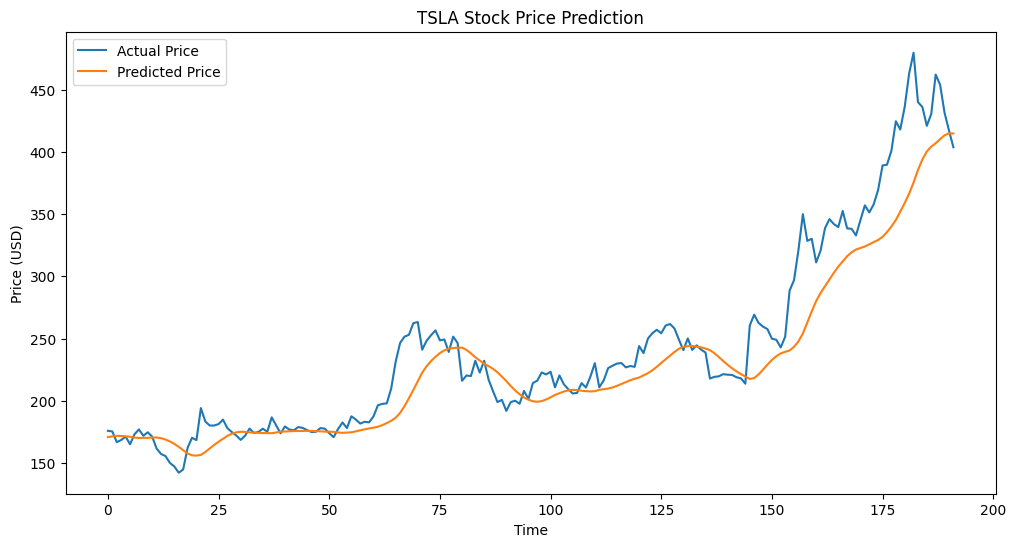

In [41]:
predictions = model.predict(X_test)
predictions = scaler.inverse_transform(predictions)

# Compare with actual prices
real_prices = scaler.inverse_transform(y_test.reshape(-1,1))

plt.figure(figsize=(12,6))
plt.plot(real_prices, label="Actual Price")
plt.plot(predictions, label="Predicted Price")
plt.title(f"{stock_symbol} Stock Price Prediction")
plt.xlabel("Time")
plt.ylabel("Price (USD)")
plt.legend()
plt.show()

Create Interactive Dashboard with Dash and Plotly

In [44]:
# Historical Closing Price Line Chart
fig_close_only = go.Figure()
fig_close_only.add_trace(go.Scatter(x=data.index, y=data['Close'], mode='lines', name='Closing Price'))
fig_close_only.update_layout(title=f"{stock_symbol} Historical Closing Prices",
                        xaxis_title="Date", yaxis_title="Price (USD)")
fig_close_only.show()

# Historical Volume Bar Chart
fig_volume_only = go.Figure()
fig_volume_only.add_trace(go.Bar(x=data.index, y=data['Volume'], name='Volume'))
fig_volume_only.update_layout(title=f"{stock_symbol} Trading Volume",
                         xaxis_title="Date", yaxis_title="Volume")
fig_volume_only.show()

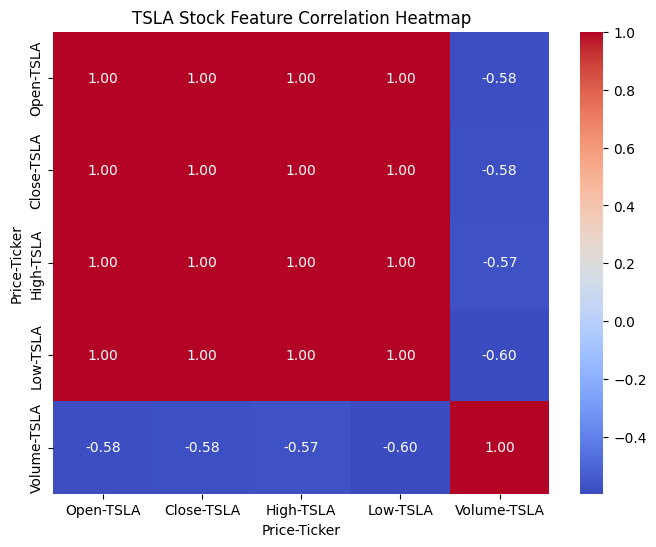

In [45]:
import seaborn as sns

# Calculate the correlation matrix
correlation_matrix = data[['Open', 'Close', 'High', 'Low', 'Volume']].corr()

# Create the heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title(f"{stock_symbol} Stock Feature Correlation Heatmap")
plt.show()

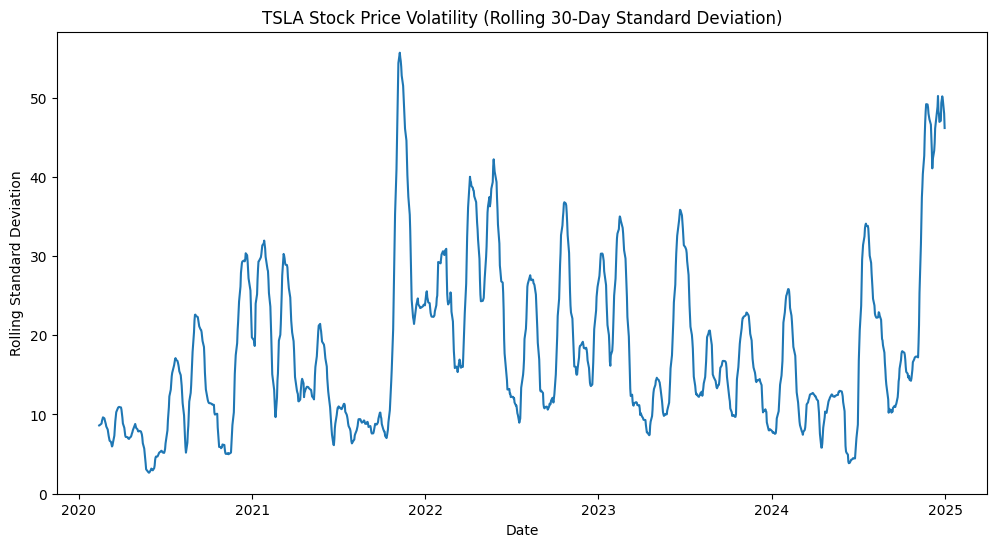

In [46]:
# Calculate rolling standard deviation for volatility
window_size = 30 # You can adjust the window size
data['Rolling_Std_Dev'] = data['Close'].rolling(window=window_size).std()

# Plot the volatility
plt.figure(figsize=(12, 6))
plt.plot(data.index, data['Rolling_Std_Dev'])
plt.title(f"{stock_symbol} Stock Price Volatility (Rolling {window_size}-Day Standard Deviation)")
plt.xlabel("Date")
plt.ylabel("Rolling Standard Deviation")
plt.show()

Calculate and Plot RSI

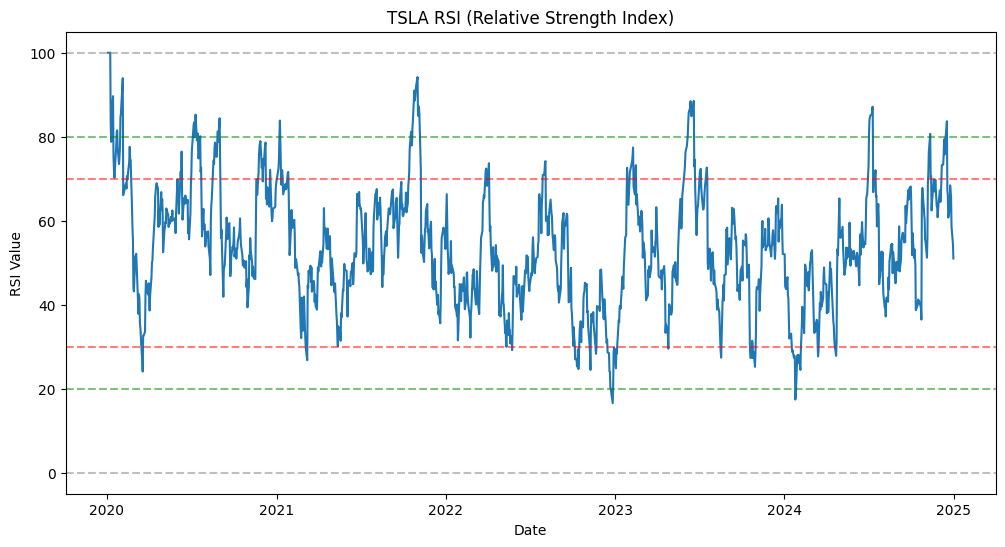

In [47]:
def calculate_rsi(data, window=14):
    delta = data['Close'].diff()
    gain = (delta.where(delta > 0, 0)).fillna(0)
    loss = (-delta.where(delta < 0, 0)).fillna(0)
    avg_gain = gain.ewm(com=window-1, adjust=False).mean()
    avg_loss = loss.ewm(com=window-1, adjust=False).mean()
    rs = avg_gain / avg_loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

data['RSI'] = calculate_rsi(data)

plt.figure(figsize=(12, 6))
plt.plot(data.index, data['RSI'])
plt.title(f"{stock_symbol} RSI (Relative Strength Index)")
plt.xlabel("Date")
plt.ylabel("RSI Value")
plt.axhline(0, linestyle='--', alpha=0.5, color='gray')
plt.axhline(20, linestyle='--', alpha=0.5, color='green')
plt.axhline(30, linestyle='--', alpha=0.5, color='red')
plt.axhline(70, linestyle='--', alpha=0.5, color='red')
plt.axhline(80, linestyle='--', alpha=0.5, color='green')
plt.axhline(100, linestyle='--', alpha=0.5, color='gray')
plt.show()

Plot Returns Distribution

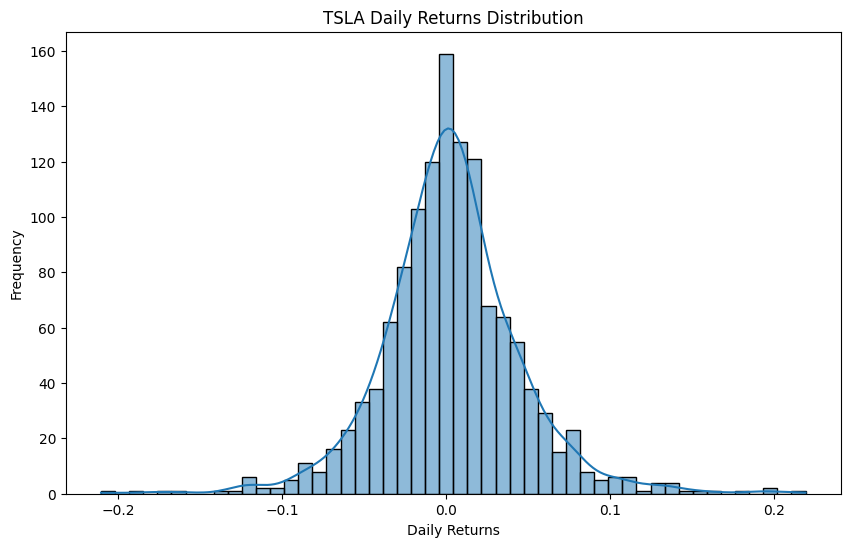

In [48]:
data['Daily_Returns'] = data['Close'].pct_change().dropna()

plt.figure(figsize=(10, 6))
sns.histplot(data['Daily_Returns'], bins=50, kde=True)
plt.title(f"{stock_symbol} Daily Returns Distribution")
plt.xlabel("Daily Returns")
plt.ylabel("Frequency")
plt.show()

Plot Training Loss Curve